# STAT 301 Group 19 - Final Project Report

### 1. Introduction

The primary goal of our analysis is to analyze potential predictors to determine the odds of an employee staying or leaving a company, which will be conducted using the Employees dataset.

The Employees dataset is comprised of anonymized information about employees in company, including: highest education level, work history, location, salary, demographics, and information regarding their work with the company. This data was collected by the company Human Resources department and contributed to Kaggle, a community offering data science resources and tools.

#### Overview of variables:
- **Education** *(categorical)*: chr representing the highest level of education attained by the employee.

- **JoiningYear** *(numerical)*: dbl representing the year a given employee first started working for the company.

- **City** *(categorical)*: chr representing the city in which an employee works for the company.

- **PaymentTier** *(categorical)*: dbl representing a bin containing an employee's salary.

- **Age** *(numerical)*: dbl representing the age of employees working at a company.

- **Gender** *(categorical)*: chr representing the sex of employees working at a company.

- **EverBenched** *(binary)*: chr representing whether or not an employee has been benched, ie. had a period of time without work assigned to them.

- **ExperienceInCurrentDomain** *(categorical)*: dbl representing the years of experience an employee has in the area of their role prior to joining the company.

- **LeaveOrNot** *(binary)*: dbl representing whether an employee left of not.

In order to select a model, we'd analyze the relation of these predictors with our response, LeaveOrNot, as well as their relationships with each other to determine the presence of interaction. Once our analysis is complete, we would then train a logistic model using these predictors to predict an employee's odds of leaving using a testing set. A logistic model was selected as our response is a binary variable.

Our data supports this goal by providing information on all of these predictors, however, we will need to transform the data by pre-processing variables and dropping variables we do not wish to include.

**We included the following predictors:**
- **Education, ExperienceinCurrentDomain, and Age** provide information on an employee's prior qualifications prior to starting to work at the company. This  provides a glimpse into the employee's professional background and an approximation of their career stage.

- Prior literature suggests that salary (**PaymentTier**) has a positive relationship with employee retention, hence its inclusion

- **EverBenched** is relevant as if employees went prolonged periods without access to work or other meaningful tasks, they may develop a negative perception of their experience with the company .

- **City** would allow for more generalization as the model could account for specific municipal or location-based factors, including workplace culture

**We excluded the following predictors:**
- Gender: We elected to not include Gender for two reasons. The first is that this isn't inclusive as when the data was collected, Gender was presented as a binary option when in practice, many people identify as genders beyond the binary. This also may introduce a response bias, as participants who identify as a non-binary gender would be required to incorrectly list their gender identity without an option to not disclose this information. Secondly, this may skew information due to differing societal expectations of men and women in the workplace. We do in fact live in a patriarchal society where women starting families are pressured to bear the majority of childcare responsibilities which may impact whether a female employee chooses to leave the company. 

- JoiningYear: We elected to exclude this as we felt that it wouldn't be able to provide much context without other information that we did not have access to. For example, if we wanted to use JoiningYear to determine how long an employee has worked at the company, we would be unable to do so without access to data and information on when an employee left the company (if applicable). This approach is also flawed in that we won’t know how long an employee marked as staying is planning on continuing at the company (ex. There is no difference between an employee leaving in 1 day vs 1 year).


### 2. Methods and Results
#### a. Exploratory Data Analysis

In [2]:
# Attaching packages. Source: Course worksheets
library(plyr)
library(dplyr)
library(tidyverse)
library(cowplot)
library(ggplot2)
library(reshape2)
library(repr)
library(infer)
library(broom)
library(AER)
library(modelr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.4
✔ ggplot2   3.4.4     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::arrange()   masks plyr::arrange()
✖ purrr::compact()   masks plyr::compact()
✖ dplyr::count()     masks plyr::count()
✖ dplyr::desc()      masks plyr::desc()
✖ dplyr::failwith()  masks plyr::failwith()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::id()        masks plyr::id()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr

In [18]:
employee <- read.csv("data/Employee.csv", header = TRUE)

employee <- employee %>%
    select(-Gender, -JoiningYear)

head(employee)

,Education,City,PaymentTier,Age,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
,<chr>,<chr>,<int>,<int>,<chr>,<int>,<int>
1,Bachelors,Bangalore,3,34,No,0,0
2,Bachelors,Pune,1,28,No,3,1
3,Bachelors,New Delhi,3,38,No,2,0
4,Masters,Bangalore,3,27,No,5,1
5,Masters,Pune,3,24,Yes,2,1
6,Bachelors,Bangalore,3,22,No,0,0


In [19]:
unique(employee$LeaveOrNot) # 2 levels (0, 1)
unique(employee$ExperienceInCurrentDomain) # 8 levels (0 - 7)
unique(employee$EverBenched) #  2 levels ("No" and "Yes")
unique(employee$PaymentTier) # 3 levels (1, 2, and 3)
unique(employee$City) # 3 levels ("Bangalore", "Pune", and "New Delhi")
unique(employee$Education) # 3 levels ("Bachelors", "Masters", and "PHD")

[1] 0 1

[1] 0 3 2 5 1 4 7 6

[1] "No"  "Yes"

[1] 3 1 2

[1] "Bangalore" "Pune"      "New Delhi"

[1] "Bachelors" "Masters"   "PHD"

In [21]:
employee <- employee |>
    mutate(EverBenched = ifelse(EverBenched == "Yes", 1, 0),   # EverBenched into 0 for "No" and 1 for "Yes"
           City = ifelse(City == "Pune", 1,
                        ifelse(City == "New Delhi", 2, 0)),   # "Bangalore" is 0, "Pune" is 1, "New Delhi" is 2
           Education = ifelse(Education == "Masters", 1,
                             ifelse(Education == "PHD", 2, 0)))   # "Bachelors" is 0, "Masters" is 1, "PHD" is 2
head(employee)

,Education,City,PaymentTier,Age,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<int>
1,0,0,3,34,0,0,0
2,0,1,1,28,0,3,1
3,0,2,3,38,0,2,0
4,1,0,3,27,0,5,1
5,1,1,3,24,1,2,1
6,0,0,3,22,0,0,0


#### b. Methods and Plan

#### Making a Heatmap!

Using a **heatmap**, we evaluated the correlation of all our predictors with response and each other. We then used the results of our heatmap to guide whether we include or exclude a predictor in our analysis. 

In [23]:
corr_matrix_employee <- 
   employee %>%
   cor() %>%
   as_tibble(rownames = 'var1') %>%
   pivot_longer(-var1, names_to = "var2", values_to = "corr")

head(corr_matrix_employee)

var1,var2,corr
<chr>,<chr>,<dbl>
Education,Education,1.000000000
Education,City,0.390889582
Education,PaymentTier,-0.140741037
Education,Age,-0.010611066
Education,EverBenched,-0.052248638
Education,ExperienceInCurrentDomain,-0.004462647


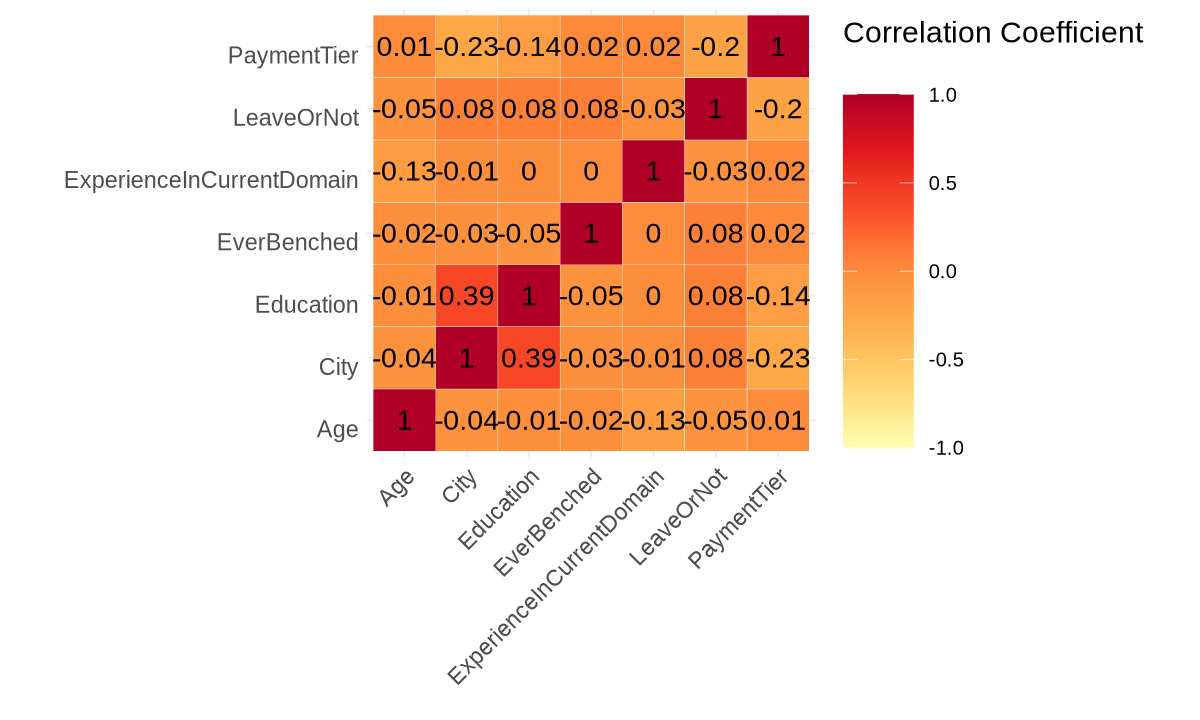

In [24]:
options(repr.plot.width = 10, repr.plot.height = 6) 

employee_processed_plot <- 
  corr_matrix_employee %>%
  ggplot(aes(var1, var2)) +
  geom_tile(aes(fill = corr), color = "white") +
  scale_fill_distiller("Correlation Coefficient \n",
      palette =  "YlOrRd",
      direction = 1, 
      limits = c(-1, 1)
    ) +
    labs(x = "", y = "") +
    theme_minimal() +
    theme(
        axis.text.x = element_text(angle = 45, vjust = 1, size = 14, hjust = 1),
        axis.text.y = element_text(vjust = 1, size = 14, hjust = 1),
        legend.title = element_text(size = 18),
        legend.text = element_text(size = 12),
        legend.key.size = unit(1.5, "cm")
    ) +
    coord_fixed() + geom_text(aes(var1, var2, label = round(corr, 2)), color = "black", size = 6)

employee_processed_plot

#### Interpreting the Heatmap:

Based on the results of our heatmap, none of our predictors are highly correlated with each other (corr ranges from -0.14 to 0.39). This suggests that our predictors don't interact with each other very much. This suggests that an additive model would be appropriate given the lack of interaction between predictors. 

Additionally, our predictors (when considered individually) aren't very correlated with our response, LeaveOrNot (corr ranges from -0.05 to 0.2). When considered together, it may be possible to develop a more reliable model. As such, we elected to not exclude any predictors.

### 3. Discussion

### 4. References